### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [0]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [0]:
States_track = collections.defaultdict(dict)
Q_dict = collections.defaultdict(dict)
Q_val_all= collections.defaultdict(dict)

In [0]:
def add_to_dict(state):            
    if state not in Q_dict.keys() :
        poss_actions_index, poss_actions = env.requests(state)
        for action in poss_actions:
            Q_dict[state][action]=0

In [0]:
def initialise_tracking_states():
    sample_q_values = [((1,12,6),(1,5)), ((2,5,3),(3,4)), ((5,15,2),(2,3)), ((1,19,3),(3,1)), ((4,11,4),(4,2)), ((3,5,2),(3,2)), ((2,18,3),(4,3))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [0]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])   

In [0]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [0]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001      
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003 
        self.epsilon_min = 0.00000001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(200, input_dim=self.state_size, activation='relu'))
        model.add(Dense(150, activation='relu'))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(action_size, activation='linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model


    #issue with get action
    def get_action(self, state):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)        
        poss_actions_index, poss_actions = env.requests(state)
        
        if np.random.rand()<= epsilon:
            return random.choice(poss_actions)
        else:  
            #print("state",state)      
            #Issue - not sure about the state i.e. which state to use.
            
            action = max(Q_dict[state],key=Q_dict[state].get)                        
            
            return action
        

    def append_sample(self, state, action, reward, next_state,terminal):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state,action,reward, next_state,terminal))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size,self.state_size))# write here
            update_input = np.zeros((self.batch_size,self.state_size))# write here
            
            actions, rewards, terminal_states = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal = mini_batch[i]
               
                add_to_dict((state))
                actions.append(action)
                rewards.append(reward)
                terminal_states.append(terminal)
                
                update_input[i]=env.state_encod_arch1(state)
                update_output[i]=env.state_encod_arch1(next_state)
                
                
            # Write your code from here
            # 1. Predict the target from earlier model            
            target=self.model.predict(update_input,batch_size =self.batch_size,verbose=0)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output) 
                
                
            #3. Update your 'update_output' and 'update_input' batch 
            for i in range(self.batch_size):
                state = mini_batch[i][0]                
                if terminal_states[i]:
                    Q_dict[state][actions[i]] = rewards[i]
                else:
                    Q_dict[state][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])                
                
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save(name)

In [0]:
Episodes = 1500
threshold = 100
rewards_per_episode=[]
avg_reward_per_episode=[]

### DQN block

In [0]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    
    env = CabDriver()
    # Call all the initialised variables of the environment
    curr_state = random.choice(env.state_space)
    state = env.state_encod_arch1(curr_state)
    state_size = len(state)
    indexs, actions = env.requests(curr_state)
    action_size = len(actions)
    
    add_to_dict((curr_state))
    #Call the DQN agent
    agent= DQNAgent(state_size,action_size)
    
    terminal_state=False
    
    #score
    score=0
    avg_reward=[]
    while not terminal_state:      
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(curr_state)
        # 2. Evaluate your reward and next state
        reward = env.reward_func(curr_state, action, Time_matrix)
        next_state , terminal_state = env.next_state_func(curr_state,action,Time_matrix)
        
        # 3. Append the experience to the memory
        agent.append_sample(curr_state, action, reward, next_state,terminal_state)
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        # 5. Keep a track of rewards, Q-values, loss
        score = score + reward    
        curr_state =  next_state
        add_to_dict((curr_state))
        avg_reward.append(reward)
    #tracking rewards    
    rewards_per_episode.append(score)
    avg_reward_per_episode.append(sum(avg_reward)/ len(avg_reward))
    if (episode == threshold-1):   
        print("initialise_tracking_states")
        initialise_tracking_states()
    if episode % threshold == 0:    
        print("episode",episode,"max reward",max(rewards_per_episode))        
        save_obj(rewards_per_episode,'Rewards')
    if ((episode) % threshold) == 0:        
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
        agent.save("Final_DQN_model.pkl")  #Saving the model .pkl file

### Tracking Convergence

Text(0, 0.5, 'reward per episode')

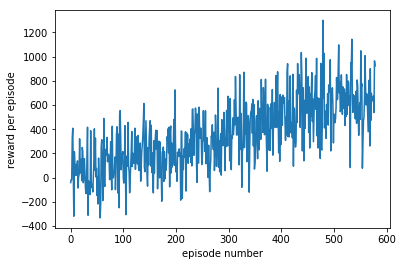

In [19]:
# Rewards per episode
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")

In [0]:
avg_reward=[]
for e in range(1,len(rewards_per_episode)):
    avg_reward.append(sum(rewards_per_episode[:e])//e)

Text(0, 0.5, 'reward per episode')

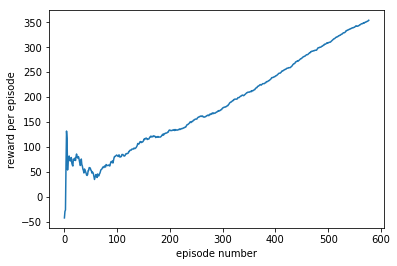

In [17]:
#Avergae rewatds
plt.plot(list(range(len(avg_reward))), avg_reward)
plt.xlabel("episode number")
plt.ylabel("reward per episode")

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [0]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

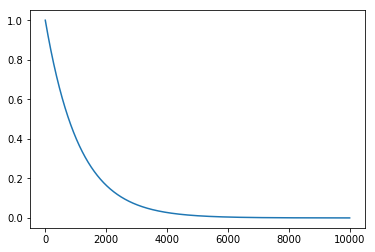

In [25]:
plt.plot(time, epsilon)
plt.show()